In [1]:
import os, glob
import numpy as np
import pandas as pd
import networkx as nx
from tqdm.auto import tqdm

root = "../data/treeoflife.interactomes_adj"
out_path = "../data/interactomes_connectivity.tsv"

def to_undirected_graph_from_dense(adj: np.ndarray) -> nx.Graph:
    """将稠密邻接矩阵转为无向图：去自环、按 (A>0)|(A.T>0) 无向化。"""
    A = np.array(adj, copy=True)
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError(f"adj must be a square 2D array, got shape {A.shape}")
    np.fill_diagonal(A, 0)
    A_und = (A > 0) | (A.T > 0)
    return nx.from_numpy_array(A_und.astype(np.int8), create_using=nx.Graph)

def analyze_graph(G: nx.Graph):
    """返回 (is_connected, n_lcc, n_total, ratio)。"""
    n_total = G.number_of_nodes()
    if n_total == 0:
        return False, 0, 0, 0.0
    if n_total == 1:
        return True, 1, 1, 1.0
    is_conn = nx.is_connected(G)
    n_lcc = n_total if is_conn else max(len(c) for c in nx.connected_components(G))
    return is_conn, n_lcc, n_total, (n_lcc / n_total)

rows = []
files = sorted(glob.glob(os.path.join(root, "**", "*.npz"), recursive=True))

for f in tqdm(files):
    try:
        adj = np.load(f, allow_pickle=False)["adj"]
        G = to_undirected_graph_from_dense(adj)
        is_conn, n_lcc, n_total, ratio = analyze_graph(G)
        rows.append([
            os.path.basename(f),
            is_conn,
            n_lcc,
            n_total,
            ratio,
        ])
    except Exception as e:
        # 出错也记录一行，方便排查
        rows.append([os.path.relpath(f, root), None, None, None, None])
        print(f"[WARN] {f}: {e}")

df = pd.DataFrame(
    rows,
    columns=["filename", "is_connected", "largest_cc_nodes", "total_nodes", "largest_cc_ratio"]
)

# 保存 TSV
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df.to_csv(out_path, sep="\t", index=False)

# 在 notebook 里显示前几行
df.head(), out_path


100%|██████████| 1840/1840 [01:23<00:00, 22.05it/s] 


(      filename  is_connected  largest_cc_nodes  total_nodes  largest_cc_ratio
 0  1000569.npz         False                21          178          0.117978
 1  1000570.npz         False               167          268          0.623134
 2  1000588.npz         False               150          254          0.590551
 3  1001530.npz         False               330          558          0.591398
 4  1001585.npz         False              1007         1398          0.720315,
 '../data/interactomes_connectivity.tsv')

max_cc_ratio < 0.2: 131


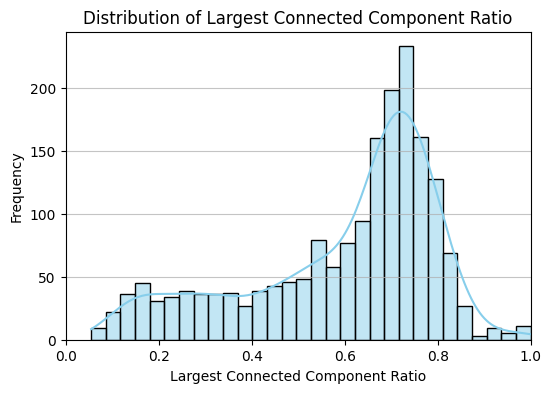

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('results/interactomes_connectivity.tsv', sep='\t')
max_cc_ratio = df['largest_cc_ratio']
print(f'max_cc_ratio < 0.2: {(max_cc_ratio < 0.2).sum()}')
# plot the distribution of max_cc_ratio
plt.figure(figsize=(6, 4), dpi=100)
sns.histplot(max_cc_ratio, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Largest Connected Component Ratio')
plt.xlabel('Largest Connected Component Ratio')
plt.ylabel('Frequency')
plt.xlim(0, 1)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [5]:
import numpy as np
import networkx as nx

def analyze_graph(G: nx.Graph):
    """返回 (is_connected, n_lcc, n_total, ratio)。"""
    n_total = G.number_of_nodes()
    if n_total == 0:
        return False, 0, 0, 0.0
    if n_total == 1:
        return True, 1, 1, 1.0
    is_conn = nx.is_connected(G)
    n_lcc = n_total if is_conn else max(len(c) for c in nx.connected_components(G))
    return is_conn, n_lcc, n_total, (n_lcc / n_total)

data = np.load('../data/treeoflife.interactomes.max_cc_adj/7260.npz')
adj = data['adj']
print(f'Adjacency matrix shape: {adj.shape}')
is_conn, n_lcc, n_total, ratio = analyze_graph(nx.from_numpy_array(adj))
print(f'Is connected: {is_conn}, Largest CC nodes: {n_lcc}, Total nodes: {n_total}, Ratio: {ratio:.4f}')

Adjacency matrix shape: (1367, 1367)
Is connected: True, Largest CC nodes: 1367, Total nodes: 1367, Ratio: 1.0000
